# Non-built Tags

## Imports & Parameters

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import rasterio
from tqdm import tqdm_notebook as tqdm

In [3]:
# Add local module to the path
src = os.path.abspath('../src')
if src not in sys.path:
    sys.path.append(src)

In [4]:
from metadata import City, CITIES
from landsat import Scene
from raster import euclidean_distance

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
def pretty(city_id):
    """Format city label."""
    name = city_id.title()
    name = name.replace('_', '-')
    return name

In [7]:
# Plotting style
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rc('font', family='serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('text', usetex=True)

## Data availability

In OpenStreetMap, three different keys can be used to find potentially non-built objects (see [Land Cover in OpenStreetMap](https://wiki.openstreetmap.org/wiki/Landcover)):

- `landuse`: mainly used to describe the primary use of land by humans;
- `natural`: used to describe a selection of geological and land cover features;
- `leisure`: places where people go in their spare time.

What tags are available in the context of our case studies?

In [8]:
tags = []

for city_name in CITIES:
    
    city = City(city_name)
    nonbuilt = city.nonbuilt
    nonbuilt['surface'] = nonbuilt.area * 1e-4
    tags.append(nonbuilt)

tags = pd.concat(tags)
tags = tags.groupby(by='tag').sum().sort_values(by='surface', ascending=False)

In [9]:
tags.head(20)

,surface
tag,
farmland,37232.874918
wetland,12577.455761
wood,5766.458769
nature_reserve,5665.836748
forest,3681.250981
park,2690.719016
golf_course,2579.892029
scrub,1280.071267
sand,967.212790


Is the availability consistent accross our case studies? Here, data availability is expressed in three different metrics:

- `count`: the total amount of non-built polygons;
- `surface`: the total surface of non-built polygons;
- `unique`: the number of unique tag values.

In [10]:
availability = pd.DataFrame(index=CITIES, columns=['count', 'surface', 'unique'])

for city_name in CITIES:
    
    city = City(city_name)
    features = city.nonbuilt
    availability.at[(city_name, 'unique')] = len(np.unique(features.tag))
    availability.at[(city_name, 'count')] = len(features)
    availability.at[(city_name, 'surface')] = np.sum(features.area * 1e-4)

In [11]:
availability.sort_values(by='surface', ascending=False)

,count,surface,unique
antananarivo,2890,33801.6,18
kampala,8856,11186.9,22
johannesburg,1589,7945.25,19
gao,104,7774,8
nairobi,1114,4910.46,18
windhoek,183,4506.88,12
saint_louis,531,3765.26,16
dakar,895,1773.62,21
katsina,49,1596.59,6
chimoio,12,63.5544,5


There is a lot of inconsistencies across the case studies. Katsina and Chimoio have very few features available (only 64 hectares are covered by non-built polygons in Chimoio). Additionnaly, Gao & Windhoek suffer from a lower amount of variety in their available tags (8 and 12) that could impact negatively the representativeness of the non-built landscape.

## Per-tag spectral analysis

In [12]:
def nearest(reference_signatures, tag_signature):
    """Find the nearest reference land cover in terms of (euclidean) spectral distance."""
    nearest_land_cover, distance = None, 99
    for land_cover, sign_ref in reference_signatures.items():
        distance_ = euclidean_distance(tag_signature, sign_ref)
        if distance_ < distance:
            distance = distance_
            nearest_land_cover = land_cover
    return nearest_land_cover

In [16]:
tags_spectral = pd.DataFrame(index=tags.index, columns=CITIES)
tags_spectral_count = pd.DataFrame(index=tags.index, columns=CITIES)

#progress = tqdm(total=len(CITIES))

for city_name in CITIES:
    
    city = City(city_name)
    scene = Scene(city.landsat_dir)
    
    nonbuilt = city.nonbuilt_raster
    legend = city.nonbuilt_tags
    
    reference_signatures = {}
    reference_raster = city.reference
    for land_cover, value in zip(('builtup', 'baresoil', 'lowveg', 'highveg'), (1, 2, 3, 4)):
        y = reference_raster == value
        reference_signatures[land_cover] = scene.signature(y)
    
    for tag, value in legend.items():
        
        y = nonbuilt == value
        tag_sign = scene.signature(y)
        tags_spectral.at[(tag, city_name)] = nearest(reference_signatures, tag_sign)
        tags_spectral_count.at[(tag, city_name)] = np.count_nonzero(y)
        
    #progress.update(1)

#progress.close()

In [17]:
tags_spectral

,antananarivo,chimoio,dakar,gao,johannesburg,kampala,katsina,nairobi,saint_louis,windhoek
tag,,,,,,,,,,
farmland,builtup,NaN,lowveg,highveg,lowveg,lowveg,baresoil,lowveg,lowveg,NaN
wetland,lowveg,NaN,highveg,builtup,highveg,highveg,NaN,lowveg,highveg,lowveg
wood,highveg,NaN,lowveg,highveg,highveg,lowveg,lowveg,highveg,lowveg,NaN
nature_reserve,NaN,NaN,highveg,NaN,builtup,NaN,NaN,NaN,highveg,lowveg
forest,highveg,NaN,builtup,NaN,highveg,highveg,NaN,highveg,NaN,NaN
park,highveg,baresoil,builtup,builtup,lowveg,lowveg,lowveg,lowveg,baresoil,highveg
golf_course,baresoil,NaN,highveg,NaN,lowveg,lowveg,NaN,lowveg,NaN,lowveg
scrub,builtup,NaN,lowveg,builtup,lowveg,lowveg,lowveg,baresoil,builtup,lowveg
sand,NaN,NaN,baresoil,builtup,lowveg,lowveg,NaN,NaN,baresoil,NaN


In [18]:
# Use tag count to determine marker size in future plot

tags_spectral_count.replace(np.nan, 0, inplace=True)

values = tags_spectral_count.values.ravel()
values = np.ma.log(values)
values = values.filled(0)
values = values / values.max() * 200

marker_sizes = tags_spectral_count.copy()
marker_sizes[:] = values.reshape(marker_sizes.shape)

In [19]:
LAND_COVER_COLORS = {
    'builtup': 'grey',
    'baresoil': 'orange',
    'lowveg': 'yellowgreen',
    'highveg': 'darkgreen'
}

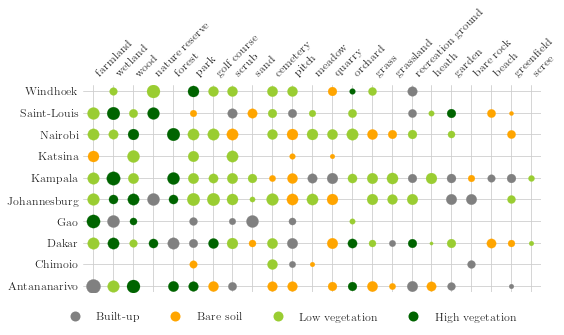

In [30]:
f, ax = plt.subplots(figsize=(8, 5))

ax.set_xticks(np.arange(len(tags_spectral.index)))
ax.set_xticklabels([tag.replace('_', ' ') for tag in tags_spectral.index], rotation=45, ha='left')
ax.xaxis.tick_top()

ax.set_yticks(np.arange(len(CITIES)))
ax.set_yticklabels(map(pretty, CITIES))
ax.set_ylim(-0.3, 9.3)
ax.set_xlim(-0.5, 22.5)

for spine in ['right', 'left', 'top', 'bottom']:
    ax.spines[spine].set_visible(False)

for i, tag in enumerate(tags_spectral.index):
    
    land_covers = tags_spectral.loc[tag]
    sizes = marker_sizes.loc[tag]
    
    for j, (key, size) in enumerate(zip(land_covers, sizes)):
        
        if not pd.isna(key):
            
            color = LAND_COVER_COLORS[key]            
            ax.scatter(i, j, color=color, s=size, marker='o')

legend_elements = [
    Line2D([0], [0], color='w', markerfacecolor='grey', markersize=10, marker='o', label='Built-up'),
    Line2D([0], [0], color='w', markerfacecolor='orange', markersize=10, marker='o', label='Bare soil'),
    Line2D([0], [0], color='w', markerfacecolor='yellowgreen', markersize=10, marker='o', label='Low vegetation'),
    Line2D([0], [0], color='w', markerfacecolor='darkgreen', markersize=10, marker='o', label='High vegetation')
]

ax.legend(handles=legend_elements, ncol=4, loc='lower center', bbox_to_anchor=[0.45, -0.2])

f.tight_layout();

f.savefig('../paper/figures/nonbuilt_similarity.png', dpi=600, bbox_inches='tight')
f.savefig('../paper/figures/nonbuilt_similarity.pdf', bbox_inches='tight');